In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot
from plotly.subplots import make_subplots
import glob
import tqdm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import itertools

In [2]:
import os

if not os.path.exists("images"):
    os.mkdir("images")

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('US_AQI.csv')
df.shape

(5617325, 15)

In [5]:
df.head()

Unnamed: 0  CBSA Code        Date  AQI Category Defining Parameter  \
0           0      10140  2022-01-01   21     Good              PM2.5   
1           1      10140  2022-01-02   12     Good              PM2.5   
2           2      10140  2022-01-03   18     Good              PM2.5   
3           3      10140  2022-01-04   19     Good              PM2.5   
4           4      10140  2022-01-05   17     Good              PM2.5   

   Number of Sites Reporting city_ascii state_id  state_name      lat  \
0                          2   Aberdeen       WA  Washington  46.9757   
1                          2   Aberdeen       WA  Washington  46.9757   
2                          2   Aberdeen       WA  Washington  46.9757   
3                          2   Aberdeen       WA  Washington  46.9757   
4                          2   Aberdeen       WA  Washington  46.9757   

        lng  population  density             timezone  
0 -123.8094     16571.0    588.0  America/Los_Angeles  
1 -123.8094     16571.0    588.0  America/Los_Angeles  
2 -123.8094     16571.0    588.0  America/Los_Angeles  
3 -123.8094     16571.0    588.0  America/Los_Angeles  
4 -123.8094     16571.0    588.0  America/Los_Angeles

# Feature Engineering & Data Visualization

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5617325 entries, 0 to 5617324
Data columns (total 15 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Unnamed: 0                 int64  
 1   CBSA Code                  int64  
 2   Date                       object 
 3   AQI                        int64  
 4   Category                   object 
 5   Defining Parameter         object 
 6   Number of Sites Reporting  int64  
 7   city_ascii                 object 
 8   state_id                   object 
 9   state_name                 object 
 10  lat                        float64
 11  lng                        float64
 12  population                 float64
 13  density                    float64
 14  timezone                   object 
dtypes: float64(4), int64(4), object(7)
memory usage: 642.9+ MB


In [7]:
df.drop("Unnamed: 0",axis=1,inplace=True)

In [8]:
# finding missing values

In [9]:
df.isnull().sum()

CBSA Code                    0
Date                         0
AQI                          0
Category                     0
Defining Parameter           0
Number of Sites Reporting    0
city_ascii                   0
state_id                     0
state_name                   0
lat                          0
lng                          0
population                   0
density                      0
timezone                     0
dtype: int64

We dont have any missing value column

In [10]:
df['Date']= pd.to_datetime(df['Date'])

In [11]:
df = df.set_index(['Date'])

In [12]:
label_name = []
values = []

for cat in df['Category'].unique():
    label_name.append(cat)
    values.append(df[df['Category']==cat].shape[0])
    
df_cat = pd.DataFrame(list(zip(label_name, values)),
               columns =['label_name', 'values'])

In [13]:
fig = px.pie(df_cat, values='values', names='label_name',title="How many time we measured air quality type all USA")
fig.update_traces(textposition='outside')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig.write_image("images/AQI_USA.png")
fig.show()

In [14]:
#lets find most unclean air all USA 
clean = [0]
state_name = [0]

for state in tqdm.tqdm(df["state_name"].unique()):
    each_df = df[df["state_name"]==state]
    x = each_df[each_df['Category']=='Good'].shape[0]
    y = each_df.shape[0]
    val = x*100/y
    if val>clean[0]:
        clean[0]=val
        state_name[0] = state

unclean = [100]
unclean_state_name = [0]

for state in tqdm.tqdm(df["state_name"].unique()):
    each_df = df[df["state_name"]==state]
    x = each_df[each_df['Category']=='Good'].shape[0]
    y = each_df.shape[0]
    val = x*100/y
    if val<unclean[0]:
        unclean[0]=val
        unclean_state_name[0] = state


df_clean = df[df['state_name'] == state_name[0]]

df_unclean = df[df['state_name'] == unclean_state_name[0]]


clean_label_name = []
clean_values = []

for cat in df_clean['Category'].unique():
    label_name.append(cat)
    values.append(df_clean[df_clean['Category']==cat].shape[0])
    
df_clean_display = pd.DataFrame(list(zip(clean_label_name, clean_values)),
               columns =['clean_label_name', 'clean_values'])

   
clean_label_name = []
clean_values = []

for cat in df_clean['Category'].unique():
    clean_label_name.append(cat)
    clean_values.append(df_clean[df_clean['Category']==cat].shape[0])
    


unclean_label_name = []
unclean_values = []

for cat in df_unclean['Category'].unique():
    unclean_label_name.append(cat)
    unclean_values.append(df_unclean[df_unclean['Category']==cat].shape[0])


#################################### Display ######################
fig = make_subplots(rows=1, cols=2, subplot_titles=("Most unclean state AQI category ",  "Most clean state AQI category") ,specs=[[{"type": "pie"}, {"type": "pie"}]])

fig.add_trace(go.Pie(
     values=unclean_values,
     labels=unclean_label_name,
     domain=dict(x=[0, 0.5]),
     name=unclean_state_name[0]), 
     row=1, col=1)

fig.add_trace(go.Pie(
     values=clean_values,
     labels=clean_label_name,
     domain=dict(x=[0.5, 1.0]),
     name=state_name[0]),
    row=1, col=2)

fig.write_image("images/min_max_AQI.png")

100%|█████████████████████████████| 52/52 [00:15<00:00,  3.35it/s]


In [15]:
def display_value(df):
    mean_value_each_day = []
    data = []
    
    months = [month for stamp, month in df.resample("m")]
    for day in months:
        mean_value_each_day.append(day['AQI'].mean())
        data.append(day[:1].index[0])
    
    
    my_data = pd.DataFrame(list(zip(mean_value_each_day,data)),
               columns =['mean_value_each_day', 'data'])
    my_data['data']= pd.to_datetime(my_data['data'])
    
    my_data = my_data.set_index(['data'])
    
    return my_data

In [16]:
## Let's divide data several years
df_to_2000 = df[:'2000-01-01']
df_from_2000_to_2022= df['2000-01-01':]
df_from2000_to2010 = df['2000-01-01':'2010-12-31']
df_from_2010_to_2022 = df['2011-01-01':]

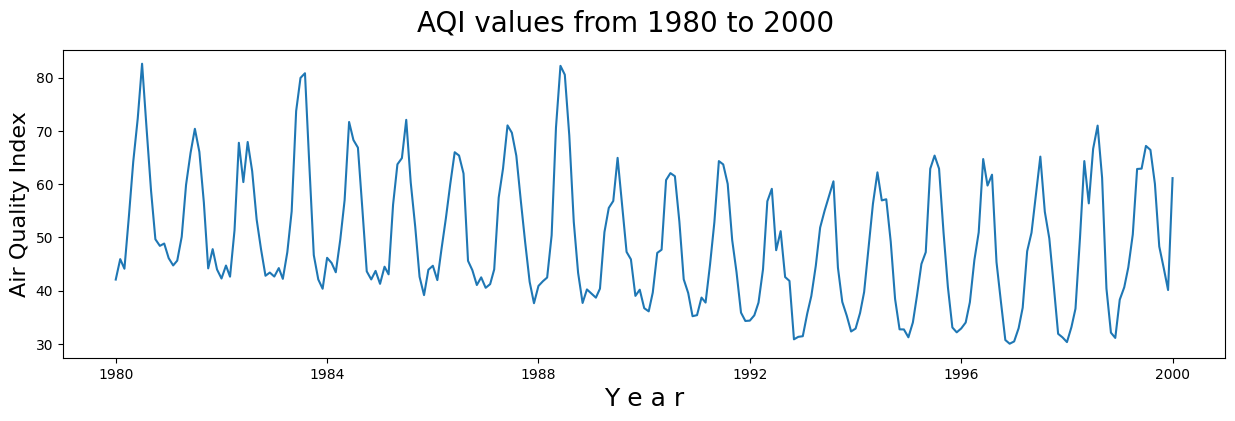

In [17]:
show_data = display_value(df_to_2000)
plt.figure(figsize=(15,4), dpi=100)
plt.plot(show_data)
plt.suptitle('AQI values from 1980 to 2000', fontsize=20)
plt.xlabel('Y e a r', fontsize=18)
plt.ylabel('Air Quality Index', fontsize=16)
plt.savefig("images/1980_2000.png")

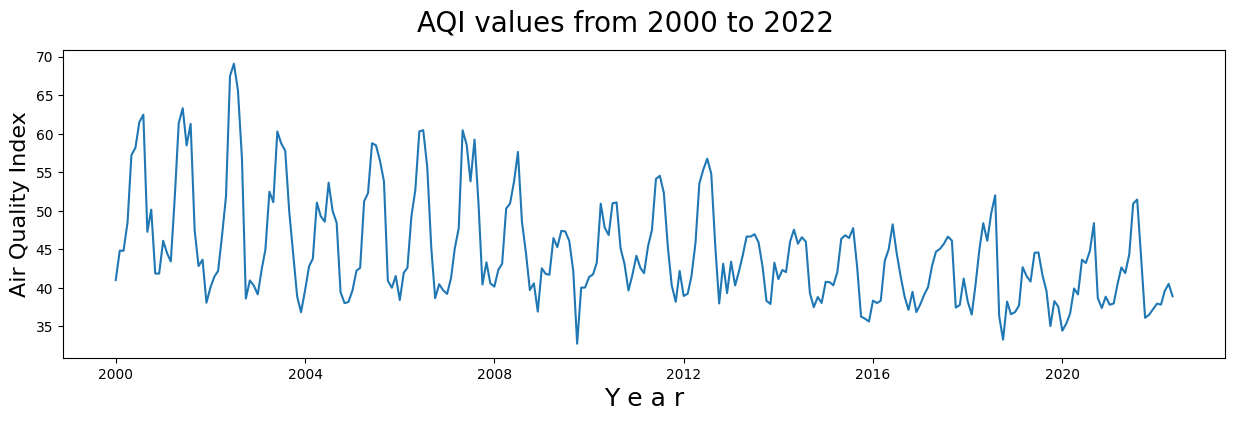

In [18]:
show_data = display_value(df_from_2000_to_2022)
plt.figure(figsize=(15,4), dpi=100)
plt.plot(show_data)
plt.suptitle('AQI values from 2000 to 2022', fontsize=20)
plt.xlabel('Y e a r', fontsize=18)
plt.ylabel('Air Quality Index', fontsize=16)
plt.savefig("images/2000_2022.png")

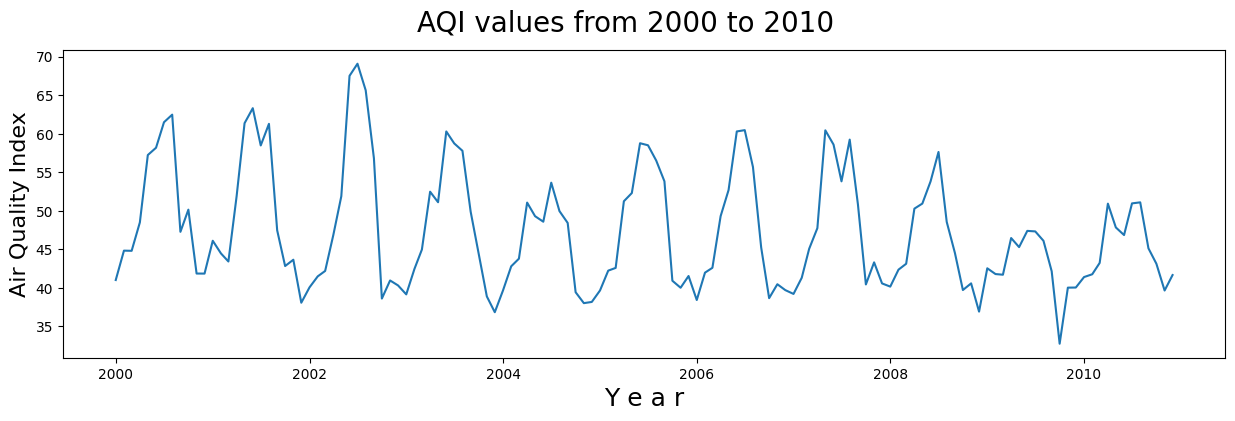

In [19]:
show_data = display_value(df_from2000_to2010)
plt.figure(figsize=(15,4), dpi=100)
plt.plot(show_data)
plt.suptitle('AQI values from 2000 to 2010', fontsize=20)
plt.xlabel('Y e a r', fontsize=18)
plt.ylabel('Air Quality Index', fontsize=16)
plt.savefig("images/2000_2010.png")

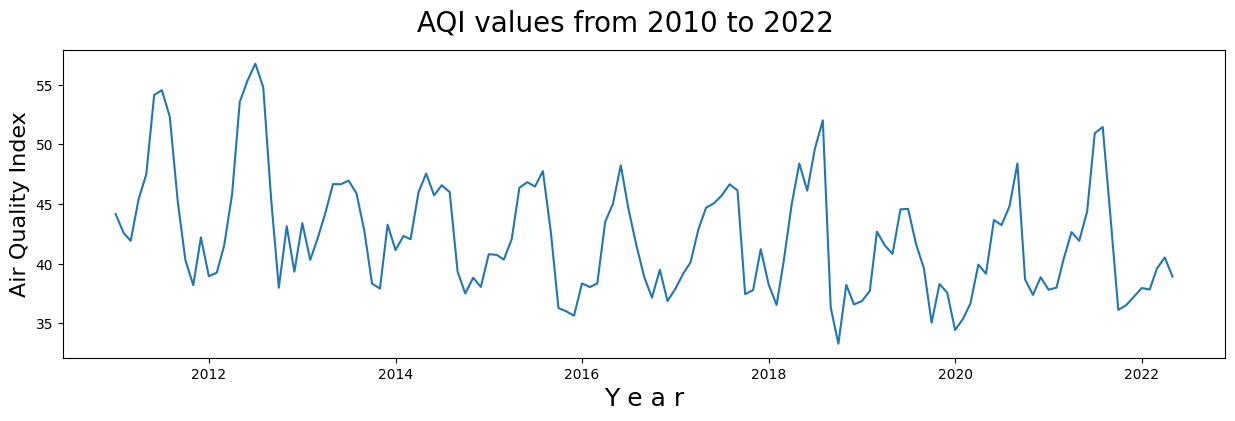

In [20]:
show_data = display_value(df_from_2010_to_2022)
plt.figure(figsize=(15,4), dpi=100)
plt.plot(show_data)
plt.suptitle('AQI values from 2010 to 2022', fontsize=20)
plt.xlabel('Y e a r', fontsize=18)
plt.ylabel('Air Quality Index', fontsize=16)
plt.savefig("images/2010_2022.png")

# Forecasting with SARIMAX

In [21]:
# for training I will drop Hazardous values beacuse it is too low 
df1 = df[df['Category']!='Hazardous']

In [22]:
months = [month for stamp, month in df1.resample("m")]

In [23]:
# Lets create mean dataset so i will just find mean values for each months
my_data = []
my_val = []
for month in months:
    my_val.append(int(month["AQI"].mean()))
    my_data.append(month[:1].index[0])
    
end_df = pd.DataFrame(list(zip(my_data, my_val)),
               columns =['my_data', 'my_val'])
end_df['my_data'] = pd.to_datetime(end_df['my_data'])
end_df = end_df.set_index(['my_data'])

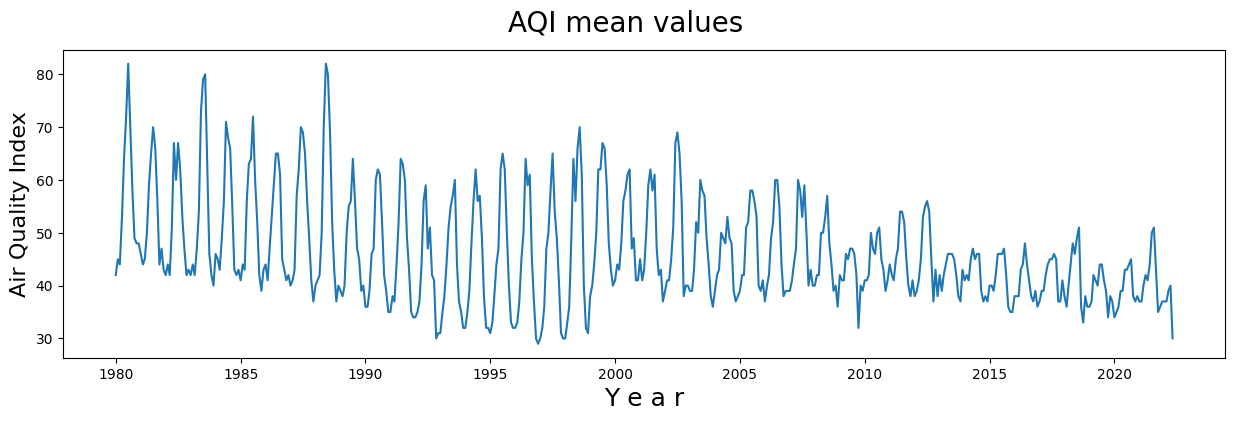

In [24]:
#Lets display our data
plt.figure(figsize=(15,4), dpi=100)
plt.plot(end_df)
plt.suptitle('AQI mean values', fontsize=20)
plt.xlabel('Y e a r', fontsize=18)
plt.ylabel('Air Quality Index', fontsize=16)
plt.savefig("images/AQI_mean.png")

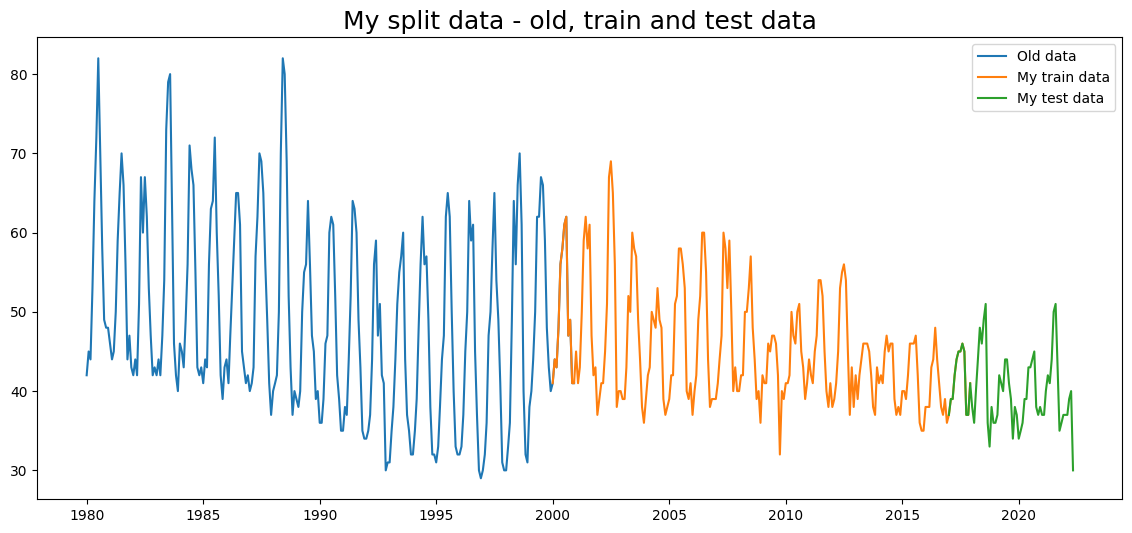

In [25]:
# Lets make split data old train and test data
old_data = end_df[:"2000"]
train_data = end_df["2000":"2017"]
test_data = end_df["2017":]

plt.figure(figsize=(14,6))
plt.title("My split data - old, train and test data",size=18)
plt.plot(old_data,label='Old data')
plt.plot(train_data,label='My train data')
plt.plot(test_data,label='My test data')
plt.legend()
plt.savefig("images/train_test_split.png")

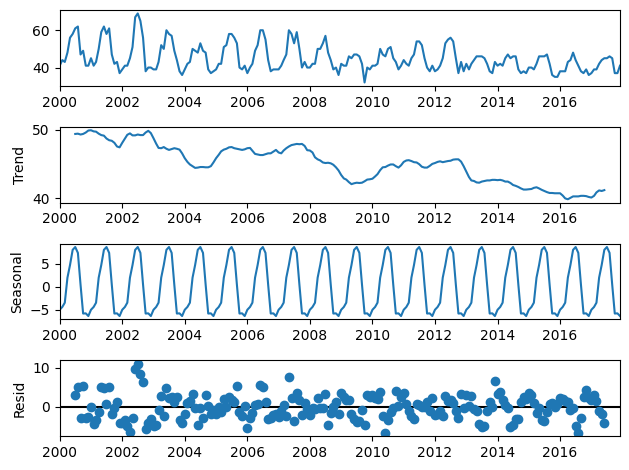

In [26]:
# visualisation data for finding seasonal or not 
decomposition = sm.tsa.seasonal_decompose(train_data,model="adaptive")
fig = decomposition.plot()
fig.show()
fig.savefig("images/seasonal_decompose.png")

In [30]:
def adfuller_test(data):
    result=adfuller(data)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is non-stationary")
        
adfuller_test(train_data)

ADF Test Statistic : -1.3722834523628376
p-value : 0.5954893116028336
#Lags Used : 11
Number of Observations Used : 204
Data is non-stationary


In [31]:
p = range(0,4)
q = range(0,4)
d = range(0,2)
P = range(0,4)
Q = range(0,4)
D = range(0,2)
pdqPQD_list  = list(itertools.product(p,q,d,P,Q,D))

In [125]:
warnings.filterwarnings('ignore')

rsme = []
order = []

for pqdPQD in tqdm.tqdm(pdqPQD_list):
    try:
        a = pqdPQD[:3]
        b = list(pqdPQD[3:])
        b.append(12)
        b = tuple(b)
        model = sm.tsa.statespace.SARIMAX(train_data['my_val'],order=a,seasonal_order=b).fit()
        pred = model.predict(start=90,end=110,dynamic=True)
        y_true = train_data['my_val'][90:111]
        eror = np.sqrt(mean_squared_error(y_true,pred))
        order.append(pqdPQD)
        rsme.append(eror)
    except:
        print("something wrong with parametr of {}".format(pqdPQD))

 73%|██████████████████████████████████████████████████████████                     | 752/1024 [19:55<13:21,  2.94s/it]

something wrong with parametr of (2, 3, 1, 1, 3, 1)


100%|██████████████████████████████████████████████████████████████████████████████| 1024/1024 [35:53<00:00,  2.10s/it]


In [126]:
prmtrs = pd.DataFrame(list(zip(rsme, order)),
               columns =['rsme', 'order'])
prmtrs.sort_values(by=['rsme'],inplace=True)

In [127]:
prmtrs

rsme               order
265     3.181601  (1, 0, 0, 1, 0, 1)
776     3.189619  (3, 0, 0, 1, 0, 1)
297     3.208493  (1, 0, 1, 1, 0, 1)
792     3.208522  (3, 0, 0, 3, 0, 1)
521     3.211516  (2, 0, 0, 1, 0, 1)
..           ...                 ...
218  2625.377287  (0, 3, 0, 3, 1, 0)
197  2648.161756  (0, 3, 0, 0, 2, 1)
205  2725.510432  (0, 3, 0, 1, 2, 1)
213  3095.995818  (0, 3, 0, 2, 2, 1)
221  3554.855714  (0, 3, 0, 3, 2, 1)

[1023 rows x 2 columns]

In [28]:
model=sm.tsa.statespace.SARIMAX(train_data['my_val'],order=(1, 0, 0),seasonal_order=(1,0,1,12))
results=model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83759D+00    |proj g|=  9.72685D-02

At iterate    5    f=  2.73570D+00    |proj g|=  1.49472D-03


 This problem is unconstrained.



At iterate   10    f=  2.72113D+00    |proj g|=  3.98975D-02

At iterate   15    f=  2.71105D+00    |proj g|=  1.46655D-02

At iterate   20    f=  2.70957D+00    |proj g|=  2.29365D-03

At iterate   25    f=  2.70350D+00    |proj g|=  1.93671D-02

At iterate   30    f=  2.70248D+00    |proj g|=  2.51508D-04

At iterate   35    f=  2.70248D+00    |proj g|=  2.51370D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     69      2     0     0   2.514D-05   2.702D+00
  F =   2.7024763800780001     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


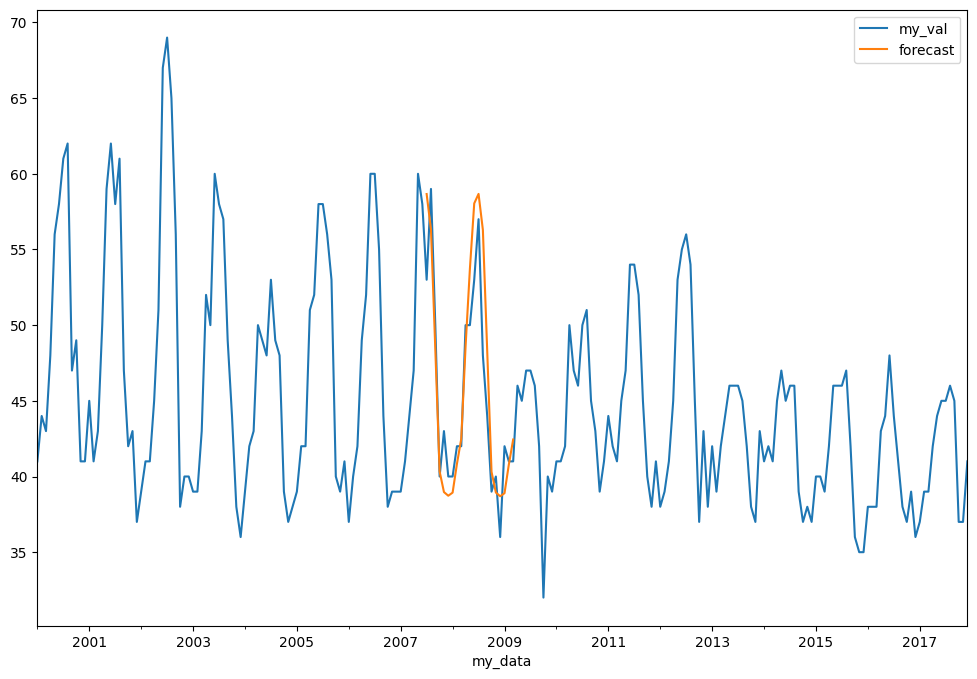

In [29]:
train_data['forecast']=results.predict(start=90,end=110,dynamic=True)
train_data[['my_val','forecast']].plot(figsize=(12,8))
plt.savefig("images/forecast_data.png")

In [30]:
model=sm.tsa.statespace.SARIMAX(test_data['my_val'],order=(1, 0, 0),seasonal_order=(1,0,1,12))
results=model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.80716D+00    |proj g|=  1.69269D+00

At iterate    5    f=  2.70978D+00    |proj g|=  4.98112D-02

At iterate   10    f=  2.69879D+00    |proj g|=  1.06289D-02


 This problem is unconstrained.



At iterate   15    f=  2.68204D+00    |proj g|=  7.96391D-04

At iterate   20    f=  2.68199D+00    |proj g|=  2.58321D-03

At iterate   25    f=  2.68150D+00    |proj g|=  2.10341D-03

At iterate   30    f=  2.68124D+00    |proj g|=  8.62669D-04

At iterate   35    f=  2.68118D+00    |proj g|=  9.54877D-04

At iterate   40    f=  2.68116D+00    |proj g|=  4.90521D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     43     69      1     0     0   2.964D-05   2.681D+00
  F =   2.6811566573941272     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [31]:
from pandas.tseries.offsets import DateOffset
future_dates=[test_data.index[-1]+ DateOffset(months=x)for x in range(0,12)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=test_data.columns)

In [32]:
future_df=pd.concat([test_data,future_datest_df])

In [33]:
future_df['forecast'] = results.predict(start = 65, end = 75, dynamic= True) 

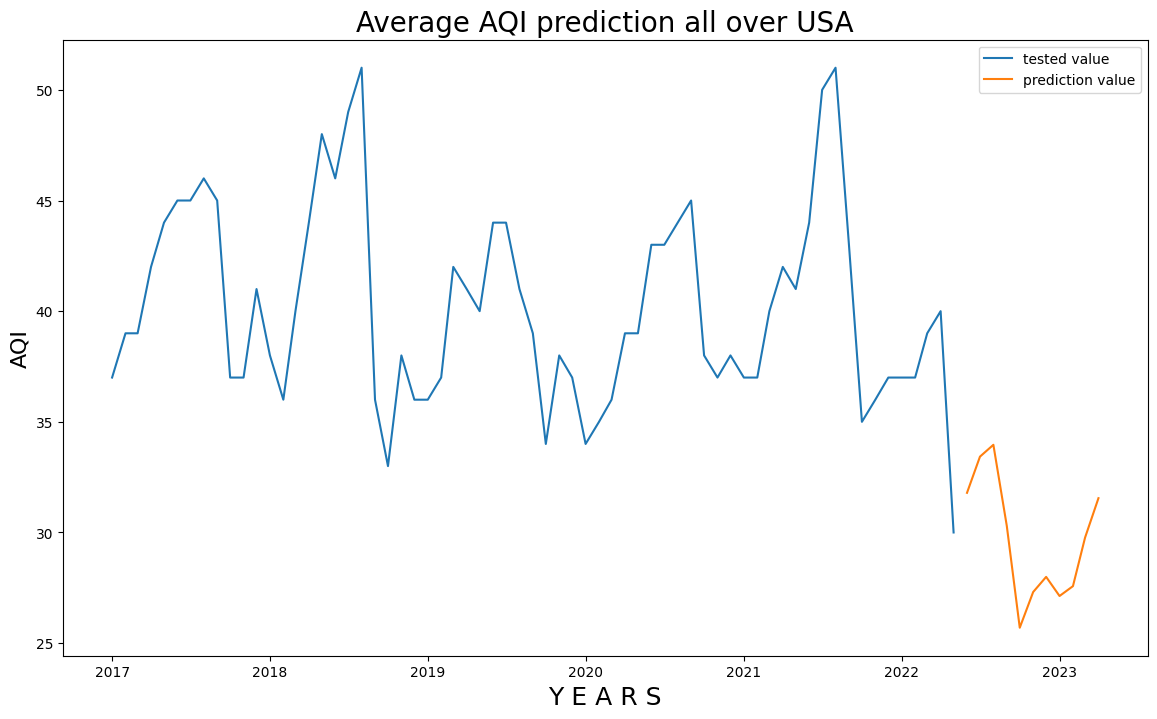

In [34]:
plt.figure(figsize=(14,8))
plt.title("Average AQI prediction all over USA",fontsize=20)
plt.plot(future_df['my_val'],label='tested value')
plt.plot(future_df['forecast'],label='prediction value')
plt.xlabel('Y E A R S', fontsize=18)
plt.ylabel('AQI', fontsize=16)
plt.legend()
plt.savefig("images/forecast_upcoming.png")